

<font size = "5"> **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Multislice Algorithm

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Diffraction/CCH2_D02-Multi_Slice.ipynb)
 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main/Diffraction/CH2_D02-Multislice.ipynb)


part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2021

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes


## Introduction
In this notebook, we will make a dynamic simulation of the scattering process.

The core of this algorithm is used in many different libraries.

I follow in my description mostly the book of Kirkland, from where we also use the scattering parameters. The code has been completely rewritten so that the mechnaism of the algorithm can be understood on a basic level. 

All commercial and open-source codes use the same base algorithm but are highly tuned for usability, variabilty, features and speed. This was not the goal here.

Here are a few of the more common open-source programs
- [abTEM](https://github.com/jacobjma/abTEM)
- [clTEM](https://github.com/JJPPeters/clTEM)
- [MuSTEM](https://github.com/ningustc/MuSTEM)
- [Dr. Probe](https://er-c.org/barthel/drprobe/)


## Load relevant python packages
### Check Installed Packages

In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install pyTEMlib -q
# pyTEMlib setup ------------------
else:
    if test_package('pyTEMlib') < '0.2021.2.5':
        print('installing pyTEMlib')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

installing pyTEMlib
done


### Import numerical and plotting python packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries, we need 3D plotting library and some scipy libraries

and a library from pyTEMlib:
* kinematic scattering library.

In [2]:
import sys
if 'google.colab' in sys.modules:
    %pylab --no-import-all inline
else:
    %pylab --no-import-all notebook

# additional package 
from mpl_toolkits.mplot3d import Axes3D 
import itertools
import scipy.constants
import scipy.special 

# Import libraries from pyTEMlib
import pyTEMlib
import pyTEMlib.KinsCat as ks         # Kinematic sCattering Library
                             # Atomic form factors from Kirklands book

#
print(pyTEMlib.__version__)# import matplotlib and numpy

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

__notebook__ = '2_Image_Registration'
__notebook_version__ = '2021_02_25'

Populating the interactive namespace from numpy and matplotlib
Using KinsCat library version  0.5  by G.Duscher
spglib not installed; Symmetry functions of spglib disabled
0.2021.02.22
pyTEM version:  0.2021.02.22


C:\Users\gduscher\Anaconda3\lib\site-packages\pyUSID\viz\__init__.py:16: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  warn('Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. '


## Overview of Multislice Algorithm

The idea is to slice the sample into thin slices that can be handled well in electron diffraction.

And then we step through these slices one by one and keep track of the incoming and exiting wave.

We seperate (serialize) the problem to conquer it.

The algorithm can be divided in several steps.

1. So first we need the projected atomic potentials for each element.
2. Then we need to build the slices. The slices are one layer of atoms which are all at the top. And then we have vacuum for the rest.
3. The transmission function will deal with the distorition of the wave by the atom potentials.
4. The Fresnel propagator takes care of the vacuum between the atomic layers.
5. We need to define the incident wave.
6. We let this wave travel through the different layers.

Step 3 is done in real space and step 4 in Fourier Space and so a lot of Fourier transfom is going on. This lends itself  speed-up through parallel fast Fourier transform algorithms, which you can see at the increasing codes with gpu usage.

## Step1: Projected Potential 

Providing the potentials and placing the atoms is a surprisingly computer intensive task for initialization of the simulation. This notebook gives up flexibility for speed in placing the atoms (no sub-pixel movement).

### Projected Potential from Parametrization of Atomic Form Factor
Following Kirkland (2$^nd$ edition Appendix C page 252),
the atom potential is with $r^2 = x^2+z^2+z^2$ and $V(x,y,z) =V(\vec{r})$ 
$$
\begin{eqnarray}
v(x, y, z) &=&  2 \pi a_0 e_0 \int f_e(q) \exp \left( -2 \pi i \vec{q} \vec{r}  \right)  d^3r \\
&=& 2 \pi^2 a_0 e_0 \sum_i \frac{a_i}{r} \exp \left( -2 \pi r  \sqrt{b_i} \right) + 2\pi^{5/2} a_0 e_0 \sum_i c_i d_i^{-3/2} \exp \left(\frac{-\pi^2 r^2}{d_i} \right)
\end{eqnarray}
$$
with $r^2 = x^2+z^2+z^2$

The ``projected potential`` is then:
$$
\begin{eqnarray}
v_z(x,y) &=& \int_{-\inf}^{\inf} V(x,y,z) dz \\
&=& 4 \pi^2 a_0 e_0 \sum_i a_i K_0 \left( 2 \pi r \sqrt{b_i} \right)
+ 2 \pi^2 a_0 e_0 \sum_i \frac{c_i}{d_i} \exp \left( \frac{-\pi^2 r^2}{d_i} \right)\\
&=& 2 \pi^2 a_0 e_0 \left[2 \sum_i a_i K_0 \left( 2 \pi r \sqrt{b_i} \right) 
+\sum_i \frac{c_i}{d_i} \exp \left( \frac{-\pi^2 r^2}{d_i} \right) \right]
\end{eqnarray}
$$
with $ r^2 = x^2 + y^2$, we need to calculate the 1D potential only, dueto the radial symmetry of atoms.

The ``spherical Bessel function`` $\bf K_0$ is providedby the ``scipy`` special package.

We will use the last of the equations in our calculation.

The setting up of the potential can take quite some computer power, so there are a few constricts in this notebook on where to put the atoms, these constricts can easily be overcome

In [3]:
def potential_1D(element, r, dx):
    """calculates the projected potential of an atom of element 
    
    The projected potential will be in units of V nm^2,
    however, internally we will use Angstrom instead of nm!
    """
    
    # get lementary constants
    a0 = scipy.constants.value('Bohr radius') * 1e10  #in Angstrom
    Ry_div_e  = scipy.constants.value('Rydberg constant times hc in eV') # in V
    e0 = 2*  Ry_div_e * scipy.constants.value('Bohr radius') * 1e10
    
    # conversion to Angstrom
    dx = dx * 10
    r = r * 10
    
    pre_factor = 2 * np.pi ** 2 * a0 * e0

    param = ks.electronFF[element]  # parametrized form factors
    fL = r*0  # Lorentzian term
    fG = r*0  # Gaussian term
    for i in range(3):
        fL += param['fa'][i] * scipy.special.k0(2 * np.pi * r * np.sqrt(param['fb'][i]))
        fG += param['fc'][i] / param['fd'][i] * np.exp(-np.pi**2 * r**2 / param['fd'][i])
    fL[0,0] = fL[0,1]
    # / 100 is back cnversion to V  nm^2 from V Angstrom^2
    return pre_factor * (2 * fL + fG) /100 # V-nm^2


To retrieve the atomic projected potential, the function above uses a rather unconventional unit for the elementary charge $e$.

Starting from the relationship for the Rydberg energy: 
$$Ry = 0.5 e^2/ a_0 $$

and using the value for $Ry$ as 13.6 eV so that $Ry/e = 13.6$ V;  we get:

$$e_0 = 2* a_0 Ry/e$$

>
>The elementary charge $e_0$ is then 1.44 V nm 
>

for $a_0 = 0.0529$ nm

In [4]:
Ry  = scipy.constants.value('Rydberg constant times hc in eV') # in V
print(f'Ry = {Ry:.4f} eV and Ry/e = {Ry:.4f} V')
e = 2*  Ry *scipy.constants.value('Bohr radius') * 1e9  # conversion to nm
print(f'elemntary charge e = {e:.4f} V nm')

Ry = 13.6057 eV and Ry/e = 13.6057 V
elemntary charge e = 1.4400 V nm


### Plot quarter of projected atom potential

We now use this function to plot a projected atom potential up in a 1nm by 1nm image. 

<IPython.core.display.Javascript object>


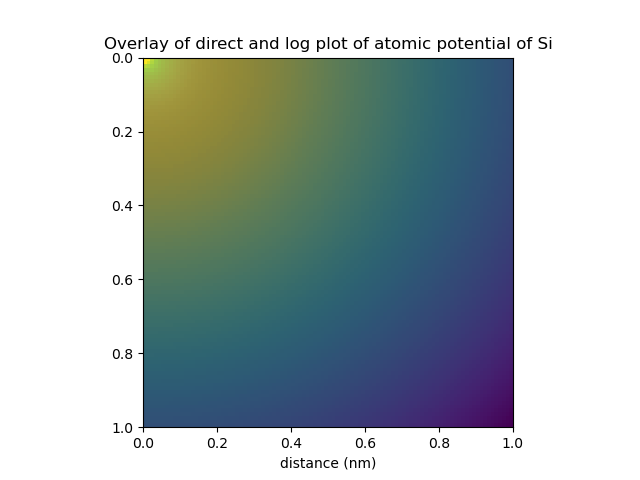

Text(0.5, 0, 'distance (nm)')

In [5]:
# ------ Input ----- #
element_name = 'Si'
# ------------------ #

pixel_size = 0.01

a_nx = a_ny = int(1/pixel_size)
x,y = np.mgrid[0:a_nx, 0:a_ny] * pixel_size

r = x**2+y**2 
#r[r<pixel_size] = pixel_size/4
atom_potential = potential_1D('Si', r, 0.02)

plt.figure()
plt.title(f'Overlay of direct and log plot of atomic potential of {element_name}')
plt.imshow(np.log(atom_potential), extent=[0,a_nx*pixel_size,a_ny*pixel_size,0])
plt.imshow(atom_potential, extent=[0,a_nx*pixel_size,a_ny*pixel_size,0], alpha =0.4)

plt.xlabel('distance (nm)')

### Plot full projected atom potential
Now, that we have a quarter of the atom potential, we make the round one, by flipping our dataset around.

<IPython.core.display.Javascript object>


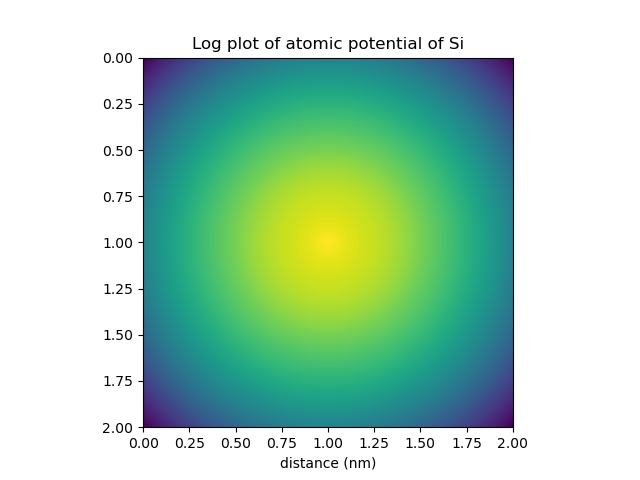

In [6]:
atom_potential_round = np.zeros([2*a_nx, 2*a_ny])
atom_potential_round[a_nx:,a_ny:] = atom_potential
atom_potential_round[a_nx:,:a_ny] = np.flip(atom_potential, axis=1)
atom_potential_round[:a_nx,a_ny:] = np.flip(atom_potential, axis=0)
atom_potential_round[:a_nx,:a_ny] = np.flip(np.flip(atom_potential, axis=0), axis=1)
plt.figure()
plt.title(f'Log plot of atomic potential of {element_name}')

plt.imshow(np.log(atom_potential_round), extent=[0,2*a_nx*pixel_size,2*a_ny*pixel_size,0])
plt.xlabel('distance (nm)');

### Embedd atoms in projected crystals

We place the atom in the corner of a matrix with the same size as the image to be simulated.

With the numpy roll function we now can move this atom wherever we want, but only with pixel precision.


<IPython.core.display.Javascript object>


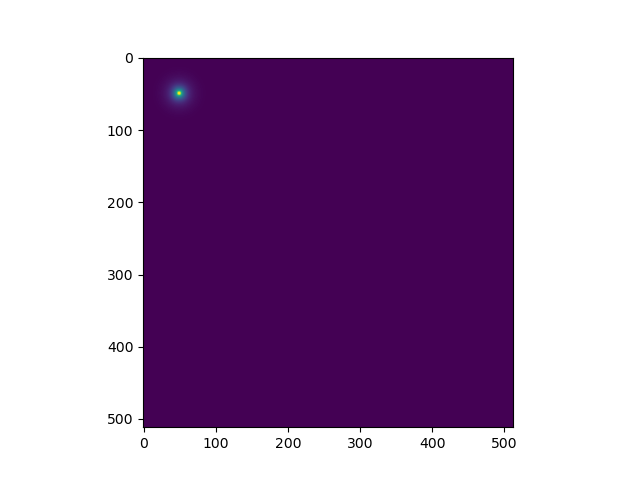

In [7]:
size_in_pixel = nx = ny =  512

atom_potential_corner = np.zeros([nx,ny])

atom_potential_corner[0:a_nx, 0:a_ny] = atom_potential
atom_potential_corner[nx-a_nx:,0:a_ny] = np.flip(atom_potential, axis=0)
atom_potential_corner[0:a_nx,ny-a_ny:] = np.flip(atom_potential, axis=1)
atom_potential_corner[nx-a_nx:,ny-a_ny:] = np.flip(np.flip(atom_potential, axis=0), axis=1)


plt.figure()
plt.imshow(np.roll(atom_potential_corner, shift = [50,50], axis = [0,1]))


### Projected Potential of Supercell

With a projected base and unit cell we know where to place the projected potentials (in pixels). We use the translational symmetery of a crystal here to multiply the portentails in the projected unitcell to make a supercell.

A more sophisticated program will allow you to place atoms potentials precisly and conveniently for each slice

<IPython.core.display.Javascript object>


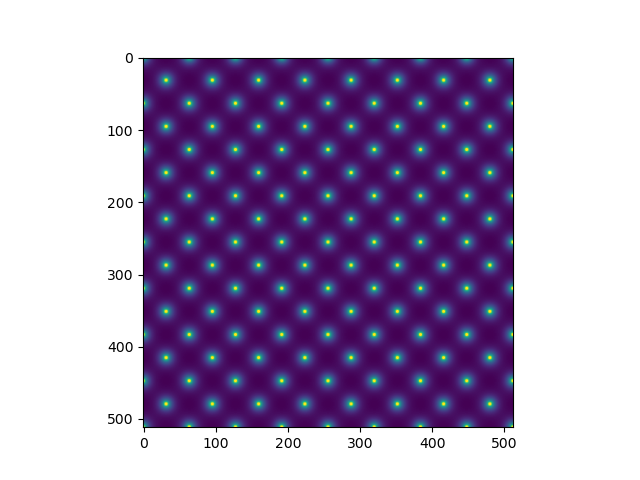

In [8]:
number_of_unit_cells_x = 8
unit_cell_base = np.array([[0.0, 0.0] , [0.5,0.5] ])

potential_unit_cell = np.zeros([nx,ny])
atom_potential_corner = np.zeros([nx,ny])

potential = np.zeros([nx,ny])

atom_potential_corner[0:a_nx, 0:a_ny] = atom_potential
atom_potential_corner[nx-a_nx:,0:a_ny] = np.flip(atom_potential, axis=0)
atom_potential_corner[0:a_nx,ny-a_ny:] = np.flip(atom_potential, axis=1)
atom_potential_corner[nx-a_nx:,ny-a_ny:] = np.flip(np.flip(atom_potential, axis=0), axis=1)

unit_cell_base = np.array(unit_cell_base*nx/8, dtype= int)

for pos in unit_cell_base:
    potential_unit_cell = potential_unit_cell + np.roll(atom_potential_corner, shift = pos, axis = [0,1])
    
for i in range(number_of_unit_cells_x):
    for j in range(number_of_unit_cells_x):
        potential = potential + np.roll(potential_unit_cell, shift = [i*64,j*64], axis = [0,1])
plt.figure()
plt.imshow((potential) )

### All together in a function

All the code from above we now collect in a single function

<IPython.core.display.Javascript object>


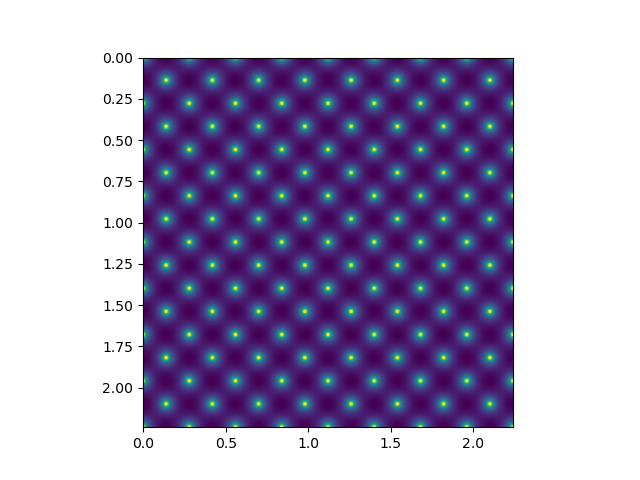

In [9]:
def potential_2D(element, nx, ny, n_cell_x, n_cell_y, lattice_parameter, base):
    n_cell_x = int(2**np.log2(n_cell_x))
    n_cell_y = int(2**np.log2(n_cell_y))
    
    pixel_size = lattice_parameter/(nx/n_cell_x)
    
    a_nx = a_ny = int(1/pixel_size)
    x,y = np.mgrid[0:a_nx, 0:a_ny] * pixel_size
    a = int(nx/n_cell_x)
    r = x**2+y**2 
    atom_potential = potential_1D(element, r, 0.02)

    potential = np.zeros([nx,ny])

    atom_potential_corner = np.zeros([nx,ny])
    atom_potential_corner[0:a_nx, 0:a_ny] = atom_potential
    atom_potential_corner[nx-a_nx:,0:a_ny] = np.flip(atom_potential, axis=0)
    atom_potential_corner[0:a_nx,ny-a_ny:] = np.flip(atom_potential, axis=1)
    atom_potential_corner[nx-a_nx:,ny-a_ny:] = np.flip(np.flip(atom_potential, axis=0), axis=1)

    unit_cell_base = np.array(base)*a
    unit_cell_base = np.array(unit_cell_base, dtype= int)
    

    for pos in unit_cell_base:
        potential = potential + np.roll(atom_potential_corner, shift=np.array(pos), axis = [0,1])
    
    for column in range(int(np.log2(n_cell_x))):
        potential = potential + np.roll(potential, shift = 2**column * a, axis = 1)
    for row in range(int(np.log2(n_cell_y))):
        potential = potential + np.roll(potential, shift = 2**row * a, axis = 0)
    
    return potential

size_in_pixel = 512
number_layers = 2
n_cell_x = 8
a = 0.28

potential = potential_2D('Si', size_in_pixel, size_in_pixel, n_cell_x, n_cell_x, a, [[0,0], [0.5,0.5]])
pixel_size = a/(nx/n_cell_x)
plt.figure()
plt.imshow((potential), extent=[0,nx*pixel_size, ny*pixel_size, 0 ])

## Step 2: Slice Crystal.

The above crystal is an artificial construct.

Now we make a real crystal. 

>
> For the multislice alogrythm we need to make the slices.
>

We do this here on the based on the unit cell 


0 Sr [0. 0. 0.]
1 Ti [0.5 0.5 0.5]
2 O [0.5 0.  0.5]
3 O [0.5 0.5 0. ]
4 O [0.  0.5 0.5]


<IPython.core.display.Javascript object>


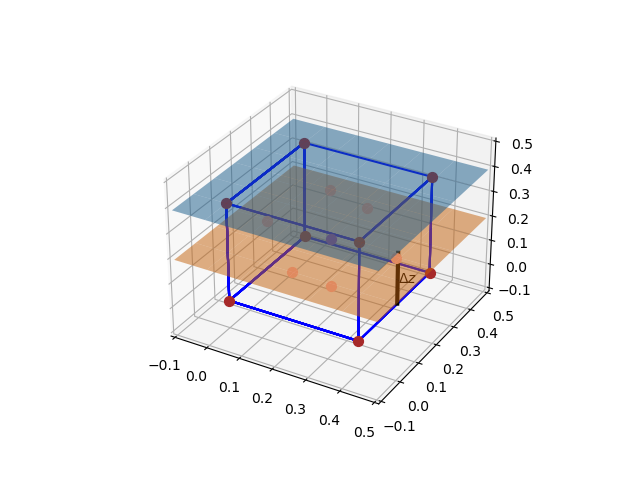

In [10]:
tags = ks.structure_by_name('SrTiO3')
for i in range(len(tags['base'])):
    print(i, tags['elements'][i], tags['base'][i])

corners, balls, atomic_number, bonds = ks.ball_and_stick(tags)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
        
cell = tags['unit_cell']

# Corners and Outline of unit cell
h = (0, 1)
corner_vectors = np.dot(np.array(list(itertools.product(h, h, h))), cell)
trace = [[0, 1], [1, 3], [3, 2], [2, 0], [0, 4], [4, 5], [5, 7], [6, 7], [6, 4], [1, 5], [2, 6], [3, 7]]
corners = []
for s, e in trace:
    corners.append([*zip(corner_vectors[s], corner_vectors[e])])

    for x, y, z in corners:
        ax.plot3D(x, y, z, color='blue')

for i, atom in enumerate(balls):
    ax.scatter(atom[0], atom[1], atom[2],
               color=tuple(ks.jmol_colors[atomic_number[i]-4]),
               alpha=1.0, s=50)
xx, yy = np.meshgrid(range(-1,6), range(-1,6))
z = xx*0+cell[2][2]
ax.plot_surface(xx/10, yy/10, z, alpha=0.5)
ax.plot_surface(xx/10, yy/10, z-cell[2][2]/2, alpha=0.5)
ax.text(0.5, 0., cell[2][2]*.7, "$\Delta z$", color='black')
ax.plot([0.5, 0.5], [0,0],zs=[cell[2][2]/2, cell[2][2]], color='black', linewidth=3)
ax.set_xlim(-0.1, 0.5)
ax.set_ylim(-0.1, 0.5)
ax.set_zlim(-0.1, 0.5);

Here we have two equidistant layers that we can read off the z-component of the base 
- one layer with z = 0.0 and 
- one layer with z = 0.5

In [11]:
lattice_parameter = tags['unit_cell'][0][0]
pixel_size = lattice_parameter/(nx/n_cell_x)

positions = np.dot(tags['base'], tags['unit_cell'])  # in pixel
for i in range(len(tags['base'])):
    print(i, tags['elements'][i], positions[i]/ pixel_size)
layers = {}
layers[0] ={0:{'element': 'Sr', 'base': [tags['base'][0, 0:2]]}, 
            1:{'element': 'O',  'base': [tags['base'][3, 0:2]]}}
layers[1] ={0:{'element': 'Ti', 'base': [tags['base'][1, 0:2]]}, 
            1:{'element': 'O',  'base': tags['base'][[2,4], 0:2]}} 
print()
print(layers)

0 Sr [0. 0. 0.]
1 Ti [32. 32. 32.]
2 O [32.  0. 32.]
3 O [32. 32.  0.]
4 O [ 0. 32. 32.]

{0: {0: {'element': 'Sr', 'base': [array([0., 0.])]}, 1: {'element': 'O', 'base': [array([0.5, 0.5])]}}, 1: {0: {'element': 'Ti', 'base': [array([0.5, 0.5])]}, 1: {'element': 'O', 'base': array([[0.5, 0. ],
       [0. , 0.5]])}}}


Make slice

Sr
O
Ti
O


<IPython.core.display.Javascript object>


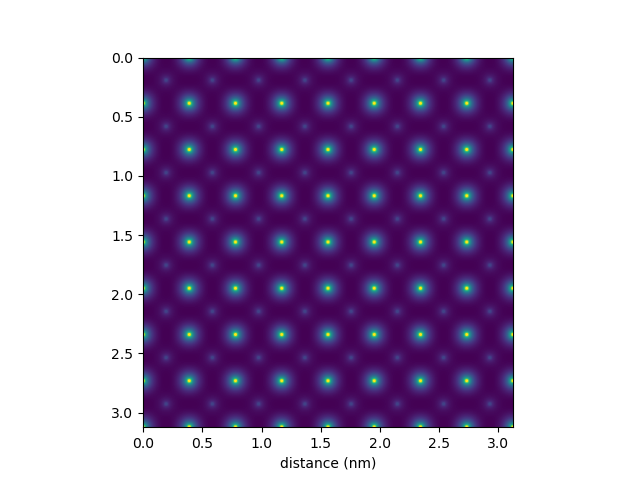

67.48663942120787


Text(0.5, 0, 'distance (nm)')

In [12]:
size_in_pixel = nx = ny = 512
n_cell_x = 8
a = tags['unit_cell'][0,0]

potential = potential_2D('Si', nx, nx, n_cell_x, n_cell_x, a, [[0,0], [0.5,0.5]])
pixel_size = a/(nx/n_cell_x)

image_extent = [0, size_in_pixel*pixel_size, size_in_pixel*pixel_size,0]
slice_potentials = np.zeros([2,512,512])
for layer in layers:
    for atom in layers[layer]:
        elem = layers[layer][atom]['element']
        print(elem)
        pos = layers[layer][atom]['base']
        slice_potentials[layer] += potential_2D(elem, nx, nx, n_cell_x, n_cell_x, a, pos)
plt.figure()
#plt.imshow(layer_potentials.sum(axis=0))
print(slice_potentials.max())
plt.imshow(slice_potentials[0], extent = image_extent)
plt.xlabel('distance (nm)')

## Step 3: Transmission Function for Each Slice 

The slice acts like a **Very Thin Specimen** in the ``weak phase approximation``.
In that approximation, the sample causes only a phase change to the incident plane wave.

To retrieve the exit wave of that slice we just multiply the transmission function $t(\vec{x})$ with the plane wave $\exp (2\pi i k_z z)$

$$ \Psi_t(\vec{x}) = t(\vec{x}) \exp \left(2 \pi i k_z z \right) \approx t(\vec{x})  $$

The specimen transmission function depends on the projected potential $v_z(\vec{x})$ and the interaction parameter $\sigma$:
$$t(\vec{x}) =  \exp \left( i \sigma v_z(\vec{x})\right)$$

with the interaction parameter $\sigma$:
$$ 
\sigma = \frac{2 \pi}{\lambda V} \left(  \frac{m_0 c^2 + eV}{2m_0c^2+eV} \right) = \frac{2 \pi m  e_0 \lambda}{h^2}
$$
with $ m = \gamma m_0$ and $eV$ the incident electron energy.

<IPython.core.display.Javascript object>


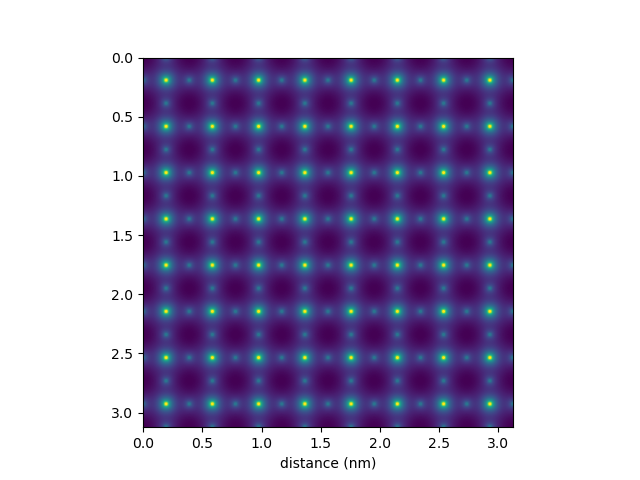

Text(0.5, 0, 'distance (nm)')

In [13]:
def interaction_parameter(acceleration_voltage):
    """Calculates interaction parameter sigma
    
    Parameter
    ---------
    acceleration_voltage: float
        acceleration voltage in volt
    
    Returns
    -------
    interaction parameter: float
        interaction parameter (dimensionless)
    """
    V = acceleration_voltage # in eV
    E0 = 510998.95 #  m_0 c^2 in eV
    
    wavelength = ks.get_wavelength(acceleration_voltage)
    E = acceleration_voltage
    
    return 2*np.pi/ (wavelength * E)  *(E0 + E)/(2*E0+E)


potential = np.array(slice_potentials, dtype=complex)

def get_transmission(sigma, potential):
    
    t = np.exp(1j*sigma* potential)
    return t
    
acceleration_voltage = 200000

sigma = interaction_parameter(acceleration_voltage)
transmission = get_transmission(sigma, potential)

plt.figure()
plt.imshow(transmission[1].imag, extent = image_extent)
plt.xlabel('distance (nm)')



## Step 4: Propagator
The Fresnel propagator $p$ propagates the wave through the vacuum of the layers between the (flat) atom potentials.
$$
p(x,y, \Delta z) = \mathcal{F} P(k_x, k_y, \Delta z)
$$
Mathematically, this propagator function has to be  convoluted with the wave, which is a multiplication in Fourier space $\mathcal{F}$.

$$
P(k,\Delta z) = \exp(-i\pi \lambda k^2 \Delta z)
$$

The Fourier space is limited in reciprocal vector to avoid aliasing. We realize that with  an aperture function.

Here we assume a cubic crystal and equidistant layers, but that of course is not always true.

[0.1952634, 0.1952634]
54.62706614074458
Bandwidth limited to a real space resolution of 18.30594375 pm
   (= 89.80 mrad)  for symmetrical anti-aliasing.
Number of symmetrical non-aliasing beams = 91528


<IPython.core.display.Javascript object>


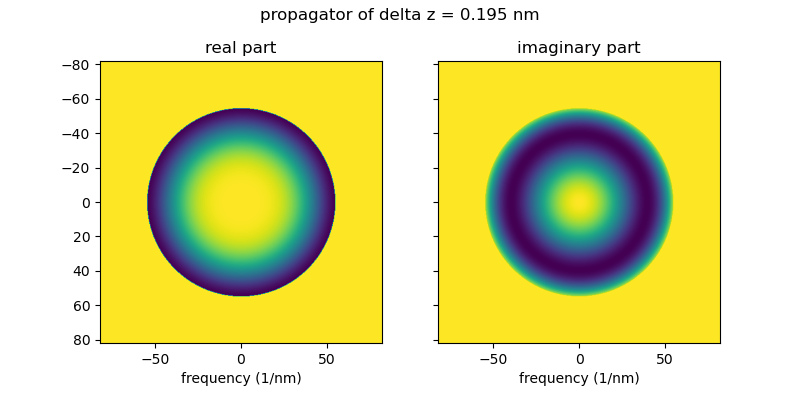

In [14]:
lattice_parameter = tags['unit_cell'][0,0]
field_of_view = 8*lattice_parameter
size_in_pixel = 512
number_layers = 2
delta_z = [tags['unit_cell'][2,2]/number_layers, tags['unit_cell'][2,2]/number_layers]
print(delta_z)
wavelength = ks.get_wavelength(400000)
bandwidth_factor = 2/3   # Antialiasing bandwidth limit factor

def get_propagator(size_in_pixel, delta_z, number_layers, wavelength, field_of_view, bandwidth_factor, verbose=True):
    
    k2max = size_in_pixel/field_of_view/2. * bandwidth_factor 
    print(k2max)
    if verbose:
        print(f"Bandwidth limited to a real space resolution of {1.0/k2max*1000} pm")
        print(f"   (= {wavelength*k2max*1000.0:.2f} mrad)  for symmetrical anti-aliasing.")
    k2max = k2max*k2max;

    kx,ky = np.mgrid[-size_in_pixel/2:size_in_pixel/2, -size_in_pixel/2:size_in_pixel/2]/field_of_view
    k_square = kx**2+ky**2
    k_square[k_square>k2max]=0 # bandwidth limiting
    
    if verbose:
        temp = np.zeros([size_in_pixel,size_in_pixel]) 
        temp[k_square>0] = 1
        print(f"Number of symmetrical non-aliasing beams = {temp.sum():.0f}")
        
    propagator = np.zeros([number_layers, size_in_pixel, size_in_pixel], dtype=complex)
    for i in range(number_layers):
        propagator[i] = np.exp(-1j*np.pi*wavelength*k_square*delta_z[i])
    
    return propagator

propagator = get_propagator(size_in_pixel, delta_z, number_layers, wavelength, field_of_view, 
                             bandwidth_factor, verbose=True)

recip_FOV = size_in_pixel/field_of_view/2.
reciprocal_extent = [-recip_FOV,recip_FOV,recip_FOV,-recip_FOV]
layer = 0
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
fig.suptitle(f"propagator of delta z = {delta_z[layer]:.3f} nm")
ax[0].set_title(f"real part")
ax[0].imshow(propagator[0].real,extent=reciprocal_extent)
ax[0].set_xlabel('frequency (1/nm)')
ax[1].set_title(f"imaginary part")
ax[1].set_xlabel('frequency (1/nm)')
ax[1].imshow(propagator[0].imag,extent=reciprocal_extent)


## Step 5: Incident Wave
That will be easy, in plane wave illumination all points have the same amplitude (here: 1) and phase (here: 0). We express that plane wave as a complex array.

A titled plane would be a little more complicated.

In [15]:
# Tilt not implemented yet
plane_wave = np.ones([nx,ny], dtype=complex)

## Step 6: Multislice Loop

Combining the transmission function $t$ and the Frensel propagator $p$ we get
for each slice:
$$
\Psi(x,y,z+\Delta z) = p(x,y,\Delta z) \otimes \left[t(x,y,z)\Psi(x,y,z) \right] + \mathcal{O}(\Delta z^2)
$$

or an expression that bettere relfects the iterative nature of this equation for starting layer n :

$$
\Psi_{n+1}(x,y,) = p_n(x,y,\Delta z) \otimes \left[t_n(x,y,z)\Psi_n(x,y,z) \right] + \mathcal{O}(\Delta z^2)
$$

Again the convolution $\otimes$ will be done as a multiplication in Fourier space.

simulated SrTiO3 for thickness 3.124 nm


<IPython.core.display.Javascript object>


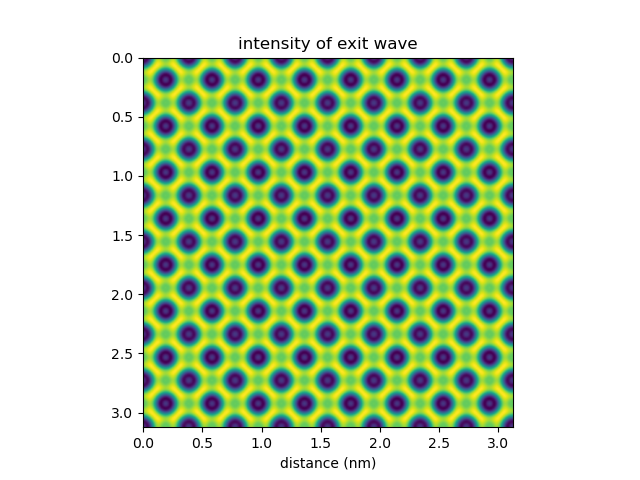

In [16]:
# ------Input------------- #
number_of_unit_cell_z = 8 # this will give us the thickness
# ------------------------ #    

def multi_slice(wave, number_of_unit_cell_z, acceleration_voltage, transmission, propagator):
    """Multislice Calculation
    
    One the array wave will be changed
    """
    sigma = interaction_parameter(acceleration_voltage)
    for i in range(number_of_unit_cell_z):
        for layer in range(number_layers): 
            wave = wave * transmission[layer] # transmission  - real space
            wave = np.fft.fft2(wave)
            wave = wave * propagator[layer]  # propagation; propagator is defined in reciprocal space
            wave = np.fft.ifft2(wave) #back to real space
    return wave

plane_wave = np.ones([size_in_pixel,size_in_pixel], dtype=complex)
exit_wave = multi_slice(plane_wave, number_of_unit_cell_z, acceleration_voltage, transmission, propagator)
    
print(f"simulated {tags['crystal_name']} for thickness {number_of_unit_cell_z*tags['unit_cell'][0,0]:.3f} nm")

wave = np.fft.fft2(exit_wave)
intensity = np.abs(np.fft.fftshift(np.fft.ifft2(wave*wave)))

plt.figure()
plt.title('intensity of exit wave')
plt.imshow(intensity, extent = image_extent)
plt.xlabel('distance (nm)');

## Diffraction Pattern

according to [J. M. Cowley and A. F. Moodie](https://doi.org/10.1107/S0365110X57002194), the diffraction pattern $U(u,v)$ is the Fourier transform of the exit wave function in the far-field (diffraction plane): 

$$
U(u,v) = \mathcal{F} \left( \exp(i*\varphi(x,y)) \right)
$$

where $\varphi$ is the exit wave of the crystal.

<IPython.core.display.Javascript object>


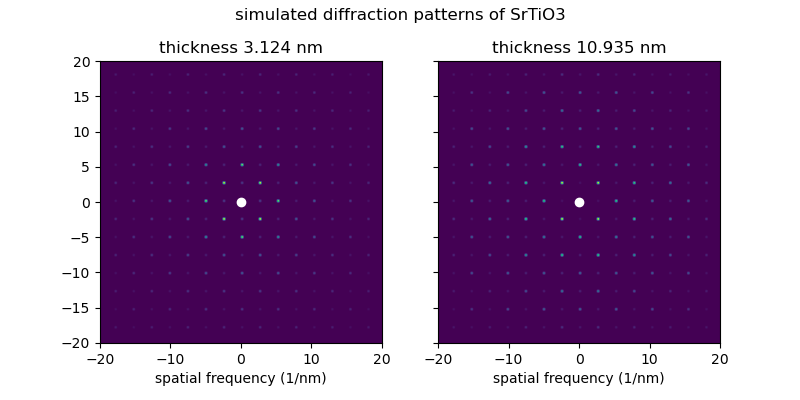

(-20.0, 20.0)

In [17]:
additional_layers = 20
diffraction_pattern = np.fft.fftshift(np.fft.fft2(np.exp(1j*exit_wave)))
diffraction_pattern[256,256] = 0

# adding a multislice calculation
exit_wave2 = multi_slice(exit_wave, additional_layers, acceleration_voltage, transmission, propagator)
diffraction_pattern2 = np.fft.fftshift(np.fft.fft2(np.exp(1j*exit_wave2)))
diffraction_pattern2[256,256] = 0

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
fig.suptitle(f"simulated diffraction patterns of {tags['crystal_name']}")
ax[0].set_title(f"thickness {number_of_unit_cell_z*tags['unit_cell'][0,0]:.3f} nm")
ax[0].imshow(np.abs(diffraction_pattern), extent=reciprocal_extent)
ax[0].set_xlabel('spatial frequency (1/nm)')
ax[1].set_title(f"thickness {(number_of_unit_cell_z+additional_layers)*tags['unit_cell'][0,0]:.3f} nm")
ax[1].imshow(np.abs(diffraction_pattern2), extent=reciprocal_extent)
ax[1].set_xlabel('spatial frequency (1/nm)')
ax[0].scatter(0,0, color='white')
ax[1].scatter(0,0, color='white')

ax[1].set_aspect('equal')
ax[1].set_xlim(-20,20)
ax[1].set_ylim(-20,20)

In [51]:
plt.close('all')

In [41]:
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

im1 = np.arange(100).reshape((10, 10))
im2 = im1.T
im3 = np.flipud(im1)
im4 = np.fliplr(im2)

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)


plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Aberration Function

The aberration function $chi(\vec{k})$ is defined in reciprocal space.

For the calculation of $chi$ we use the angles instead of reciprocal distances.

We came accross the aberration function before in the [contrast transfer function notebook](CH3-CTF.ipynb).


Please look up how we determined the different Scherzer foci in [contrast transfer function notebook](CH3-CTF.ipynb). The contrast transfer function (CTF) is just the radial average of the aberration function if all aberrations are zero except defocus (C10) and spherical aberration (C30). 


The objective lens function (or point spread function of the eletron microscope) $H_0(\vec{k})$
is defined as:
$$ 
H_0(\vec{k}) = \sin \left(\chi(\vec{k})\right)
$$
an oscillating function and at the origin of problems in electron microscopy.

In the TEM a Fourier transform of an image of an thin amorphous material will look similar (with noise) to the object function below. Compare those diffractograms with differnt defoci with those of our simulation.


Check out what the astigmatism (C12a or C12b) does to the object function.

In [46]:
def make_chi(theta, phi, wavelength, ab):
    """Calculate aberration function chi
    
    Input:
    ------
    theta, phi: numpay array (n x m)
        angle meshes of the reciprocal space
    wavelength: float
        wavelength in nm
    ab: dict
        aberrations in nm should at least contain defocus (C10), and spherical abeeration (C30) 
        
    Returns:
    --------
    chi: numpy array (nxm)
        aberration function 
    """
    if 'C10' not in ab:
        ab['C10'] = 0.
    if 'C12a' not in ab:
        ab['C12a'] = 0.
    if 'C12b' not in ab:
        ab['C12b'] = 0.
    # defocus and astigmatism
    t1 = np.power(theta, 2)/2 * (ab['C10']  + ab['C12a'] * np.cos(2 * phi) + ab['C12b'] * np.sin(2 * phi))
    

    # coma and three fold astigmatism
    if 'C21a' in ab and 'C21b' in ab and 'C23a' in ab and 'C23b' in ab:
        t2 = np.power(theta, 3)/3 * (ab['C21a'] * np.cos(1*phi) + ab['C21b'] * np.sin(1*phi))
    else:
        t2 = theta*0.
    # spherical aberration
    if 'C30' not in ab:
        ab['C30'] = 0.
    t3 = np.power(theta, 4)/4 * ab['C30']
                              
    chi = t1 + t2+ t3
    return chi * 2 * np.pi / wavelength  # np.power(theta,6)/6*(  ab['C50'] )
                           
def objective_lens_function(ab, nx, ny, field_of_view, wavelength, aperture_size=10):
    """Objective len function to be convoluted with exit wave to derive image function
    
    Input:
    ab: dict
        aberrations in nm should at least contain defocus (C10), and spherical abeeration (C30) 
    nx: int
        number of pixel in x direction
    ny: int
        number of pixel in y direction
    field_of_view: float
        field of fiew of potential
    wavelength: float
        wavelength in nm
    aperture_size: float
        aperture size in 1/nm
        
    Returns:
    --------
    object function: numpy array (nx x ny)
    extent: list
    """
    
    # Reciprocal plane in 1/nm
    dk = 1 / field_of_view
    t_xv, t_yv = np.mgrid[int(-nx/2):int(nx/2),int(-ny/2):int(ny/2)] *dk

    # define reciprocal plane in angles
    phi = np.arctan2(t_yv, t_xv)
    theta = np.arctan2(np.sqrt(t_xv**2 + t_yv**2), 1/wavelength)

    mask = theta < aperture_size * wavelength

    # calculate chi
    chi = make_chi(theta, phi, wavelength, ab)
    
    extent = [-nx/2*dk, nx/2*dk, -nx/2*dk,nx/2*dk]
    return np.sin(chi)*mask, extent

acceleration_voltage = 200000
ab={'C10':-84.0, 'C12a':0.0, 'C12b':0.0, 'C30': 2.2*1e6} # aberrations in nm

wavelength = ks.get_wavelength(acceleration_voltage)

objective_lens, extent = objective_lens_function(ab, nx, nx, nx*pixel_size, wavelength, 1/.18)
plt.figure()
plt.imshow(objective_lens, extent=extent)
plt.xlabel('reciprocal distance (1/nm)')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'reciprocal distance (1/nm)')

## Influence of Aberrations on Image

Within this weak phase object aberration, we can already investigate the influence of lens aberrations on the image.

We do now all steps together and check the effect of the aberration, acceleration voltage, aperture, and element onto the final image (in weak phase approximation).



In [19]:
nx = ny = 1024
n_cell_x = 16
a = 0.28
acceleration_voltage = 200000
resolution = 0.1
ab={'C10':-88.0, 'C12a':50.0, 'C12b':0.0, 'C30': 2.2*1e6} # aberrations in nm

potential = potential_2D('Au', nx, nx, n_cell_x, n_cell_x, a, [[0,0], [0.5,0.5]])
pixel_size = a/(nx/n_cell_x)

sigma = interaction_parameter(acceleration_voltage)
t = transmission(sigma, potential)

wavelength = ks.get_wavelength(acceleration_voltage)

objective_lens, extent_r = objective_lens_function(ab, nx, nx, nx*pixel_size, wavelength, 1/resolution)

image = np.fft.ifft2((np.fft.fft2(t))*np.fft.fftshift(objective_lens))
image = np.abs(image*np.conjugate(image))

plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(objective_lens, extent=extent_r)
ax[0].set_xlabel('reciprocal distance (1/nm)')
ax[0].set_xlim(-10,10)
ax[0].set_ylim(-10,10)

ax[1].imshow(image, extent=[0,nx*pixel_size, ny*pixel_size, 0 ])
ax[1].set_xlabel('distance (nm)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'distance (nm)')

## Summary


The weak phase object allows for a fast check on image parameters. For a quantitative image simulation we need to do dynamic scattering theory. Please go to the  [Multislice notebook](CH3-multislice.ipynb)


In [20]:
# Calculating the total 2D potentials for each layer

def DefPot2DLayer(PixImageSize, ImageRange, NLayers, MatLattice, UnitCellPot2D, dx):
    Mat2D = MatLattice[:2,:2]
    Mat2DInv = np.linalg.inv(Mat2D)
    dnx = int(round(np.linalg.norm(Mat2D[0])/(dx)))
    dny = int(round(np.linalg.norm(Mat2D[0])/(dx)))
    nx = np.linspace(0, 1, dnx, endpoint=False)
    ny = np.linspace(0, 1, dny, endpoint=False)
    
    Pot2DLayer = np.array([[[0.  \
        for i in range(PixImageSize[0])] for j in range(PixImageSize[1])]  for k in range(NLayers)])


    for i in range(NLayers): # Layers loop
        Pot2DInter = interp2d(ny, nx, UnitCellPot2D[i])
        for ScanY in range(PixImageSize[1]):
            for ScanX in range(PixImageSize[0]):
                xi = dx * np.array([ScanX - round(PixImageSize[0]/2.), \
                    ScanY - round(PixImageSize[1]/2.)], dtype=float)\
                    + np.array([ImageRange[0], ImageRange[2]])
                ni = np.dot(xi, Mat2DInv)%np.array([1,1])  # Real to Direct within 1 unit cell
                Pot2DLayer[i, ScanY, ScanX] = Pot2DInter(ni[1], ni[0])[0]
    del Mat2DInv, dnx, dny, nx, ny, i, ScanX, ScanY, xi, ni
    return Pot2DLayer


In [31]:
PixImageSize = [30,30]
NLayers = 10
Pot2DLayer = np.array([[[0.  \
        for i in range(PixImageSize[0])] for j in range(PixImageSize[1])]  for k in range(NLayers)])
print(Pot2DLayer.shape)

plt.figure()
plt.imshow(Pot2DLayer.sum(axis=0))

(10, 30, 30)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [22]:
for ScanY in range(ScanYsize):
    print('line: ',ScanY,' of ',PixImageSize[1] - ProSize)
    for ScanX  in range(ScanXsize):
        Phi_trans = Probe
        for NThickness in range(1, NLevels * NLayers+1):  # NLevels depending of thickness
                if NThickness%(NLayers)  == 0: 
                        CountLayer = NLayers-1
                else:
                        CountLayer = NThickness%(NLayers)-1
                Phi_trans = Trans2D[CountLayer, ScanY : ProSize + ScanY,\
                                                ScanX :ProSize + ScanX] * Phi_trans # real
                Phi_trans = np.fft.fftshift(Phi_trans)
                tp1 = fftpack.fft2(Phi_trans) # real to reciprocal
                tp1 = fftpack.ifft2(Projector2DK[CountLayer] * tp1) #reciprocal to real
                Phi_trans = np.fft.ifftshift(tp1)
                #Phi_trans[antialising] = 0.

NameError: name 'ScanYsize' is not defined

In [23]:
def DefPro2DK(ProPixelSize, deltaZ, NLayers, wavl, dk):
    Projector2DK = np.array([[[0.  \
           for i in range(ProPixelSize)] for j in range(ProPixelSize)]  for k in range(NLayers)], dtype=complex)

    tp1 = np.array([[[-dk*ProPixelSize/2 + dk*i,-dk*ProPixelSize/2 + dk*j]  \
           for i in range(ProPixelSize)] for j in range(ProPixelSize)])
    tp2 = np.apply_along_axis(np.linalg.norm, 2, tp1)     
    tp1 = tp2 * tp2

    for i in range(NLayers):
        Projector2DK[i] = np.vectorize(complex)(np.cos(tp1*deltaZ[i]*np.pi*wavl),\
                            np.sin(tp1*deltaZ[i]*np.pi*wavl))
    del tp1, tp2
    return Projector2DK


In [24]:
ProPixelSize = 8
dk = .1
tp1 = np.array([[[-dk*ProPixelSize/2 + dk*i,-dk*ProPixelSize/2 + dk*j]  \
           for i in range(ProPixelSize)] for j in range(ProPixelSize)])
print(tp1[:,:,0])

tp2 = np.apply_along_axis(np.linalg.norm, 2, tp1)  
print(tp2)

[[-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3]
 [-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3]
 [-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3]
 [-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3]
 [-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3]
 [-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3]
 [-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3]
 [-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3]]
[[0.56568542 0.5        0.4472136  0.41231056 0.4        0.41231056
  0.4472136  0.5       ]
 [0.5        0.42426407 0.36055513 0.31622777 0.3        0.31622777
  0.36055513 0.42426407]
 [0.4472136  0.36055513 0.28284271 0.2236068  0.2        0.2236068
  0.28284271 0.36055513]
 [0.41231056 0.31622777 0.2236068  0.14142136 0.1        0.14142136
  0.2236068  0.31622777]
 [0.4        0.3        0.2        0.1        0.         0.1
  0.2        0.3       ]
 [0.41231056 0.31622777 0.2236068  0.14142136 0.1        0.14142136
  0.2236068  0.31622777]
 [0.4472136  0.36055513 0.28284271 0.2236068  0.2        0.2236068
  0.28284271 0.36055513]
 [0.5        

In [25]:
def SimClick(self):
        ctags = self.parent.tags['Sim']
        sim = ctags

        MatLattice = ctags['JCI']['MatLattice']
        CoordinatesList = ctags['JCI']['CoordinatesList']
        Layers = ctags['JCI']['Layers']
        AtomsZLay = ctags['JCI']['AtomsZLay']
        NLayers = ctags['JCI']['NLayers']

        
        
        today = time.strftime("%Y-%m-%d_%H-%M")
        start = time.time()

        # Loading the experiment, checking variable sanity & assigning default values
        #OnlyCheck, OnlyProbe, Channeling  = sanitycalculations()
        OnlyCheck = sim['OnlyCheck']
        OnlyProbe = sim['OnlyProbe']
        Channeling = sim['Channeling']


        #ApAngle, Detectors, DetShift, V0, aberrations, OAM_value = sanityoptics()
        ApAngle = sim['ApAngle']
        Detectors = sim['Detectors']
        DetShift = sim['DetShift']
        V0 = sim['V0']
        aberrations = sim['aberrations']
        OAM_value = sim['OAM_value']

        # Aberrations:
        ab = sim['Aberrations']
        aberrations[0] = ab['C10']  #,"\tDefocus in nm.")
        
        aberrations[3] = ab['C12a'] #= aberrations[3]#,"\t2-fold astigmatism a direction in nm.")     
        aberrations[4] = ab['C12b'] #= aberrations[4]#,"\t2-fold astigmatism b direction in nm.")
        aberrations[5] = ab['C21a'] #= aberrations[5]#,"\tComma a direction in nm.")
        aberrations[6] = ab['C21b'] #= aberrations[6]#,"\tComma b direction in nm.")
        aberrations[7] = ab['C23a'] #= aberrations[7]#,"\t3-fold astigmatism a direction in nm.")
        aberrations[8] = ab['C23b'] #= aberrations[8]#,"\t3-fold astigmatism b direction in nm.")
        
        aberrations[9] = ab['C30'] #= aberrations[9]#,"\tThird order aberration (C_s) in nm.")
        aberrations[10] = ab['C32a'] #= aberrations[10]
        aberrations[11] = ab['C32b'] #= aberrations[11]
        aberrations[12] = ab['C34a'] #= aberrations[12]
        aberrations[13] = ab['C34b'] #= aberrations[13]
        
        aberrations[14] = ab['C41a'] #= aberrations[14]#,"\tFourth order aberration in nm.")
        aberrations[15] = ab['C43a'] #= aberrations[15]
        aberrations[16] = ab['C45a'] #= aberrations[16]
        aberrations[17] = ab['C50'] #= aberrations[17]#/1000000,"\tFifth order aberration in mm.")
        aberrations[18] = ab['C70'] #= aberrations[18]#/1000000,"\tSeventh order aberration in mm.")
        
                
        #FieldofView, ImgPixelsX, ImgPixelsY, Thickness	= sanityimaging()
        FieldofView = sim['FieldofView']
        ImgPixelsX = sim['ImgPixelsX']
        ImgPixelsY = sim['ImgPixelsY']
        Thickness = sim['Thickness']
        
        #PlotAmpProbe, PlotAngProbe, SaveCell, SaveChaProbe, SavePot, PlotSTEM = sanityoutput()
        PlotAmpProbe =sim['PlotAmpProbe']
        PlotAngProbe =sim['PlotAngProbe']
        SaveCell =sim['SaveCell']
        SaveChaProbe = sim['SaveChaProbe']
        SavePot = sim['SavePot']
        PlotSTEM = sim['PlotSTEM']
        
        #nmax, MaxOAM, Maxradius, ProPixelSize, PosProbChan, TransVect = sanitymisc()
        nmax = sim['nmax']
        MaxOAM = sim['MaxOAM']
        Maxradius = sim['Maxradius']
        ProPixelSize = sim['ProPixelSize']
        PosProbChan = sim['PosProbChan']
        TransVect = sim['TransVect']
        
        deltaZ = DefdeltaZ(Layers, MatLattice) # Difference in z between layers

        # Calculating the number of levels (i.e. how many times the unit cell repeats in Z)
        NLevels = int(Thickness/MatLattice[2,2])
        if NLevels == 0:
                NLevels = 1

        # Defining the variables for the imaging probe: dx, dk, kmax, xmax, dtheta, theta_max
        theta_max = 250

        # Antialiasing 
        theta_max = theta_max *3/2
        # Defining the wavelength 
        wavl = lamb(V0)
        # Some image variables
        kmax = theta_max/(1000 * wavl)
        dx = 1 / (2 * kmax)
        xmax = ProPixelSize * dx
        dk = 1/ xmax
        dtheta = 1000 * dk * wavl

        printout(today, OnlyCheck, OnlyProbe, Channeling, ApAngle, Detectors, V0, aberrations, OAM_value,\
                MatLattice, CoordinatesList, AtomsZLay, deltaZ, NLevels, Thickness, dx, dk, dtheta,\
                FieldofView, ImgPixelsX, ImgPixelsY, ProPixelSize)
        ctags['FieldofView']=FieldofView
        ctags['ImgPixelsX']=ImgPixelsX
        ctags['ImgPixelsY']=ImgPixelsY
        ctags['dx']=dx
        ctags['dk']=dk
        ctags['dtheta']=dtheta
        

        if OnlyCheck == False:
            print ("Calculation(s) start now:")
            print ()

            mask_antialising = createmask(dtheta, ProPixelSize, max(Detectors), 0, DetShift)

            # Generating the probe
            print ("\tCalculating the electron probe...")
            Probe = createprobe(wavl, dtheta, ApAngle, ProPixelSize, aberrations, OAM_value)
            
            probe = self.parent.ProbeDialog.probe.calProbe()
            ctags['probe2'] = Probe
            Probe = probe
            
            #Probe[mask_antialising] = 0. # Antialiasing the probe
            tp1 = np.sum(Probe * np.conjugate(Probe))
            Probe = Probe/np.sqrt(tp1)
            ctags['Probe'] = Probe
            
            #Generates a plot of the 2D electron probe intensity & phase (PNG)
            plotProbe(Probe, dx, today, OnlyProbe, PlotAmpProbe, PlotAngProbe)

            if OnlyProbe == False:

                # Defining maximum number of pixels for the potentials and the range of the potentials in nm
                # (xmin, xmax, ymin,ymax)
                ImageRange, PixImageSize = ImageRange_ImageSize(MatLattice, ProPixelSize, dx)
                

                if Channeling == True:
                        PixImageSize = np.array([ProPixelSize, ProPixelSize])
                        tp1 = np.dot(PosProbChan, MatLattice[:2,:2]) # Position probe in real space
                        ImageRange = np.array([-dx * ProPixelSize/2. + tp1[0], 0., -dx * ProPixelSize/2. + tp1[1], 0.])

                print ("\tCalculating the scattering potentials...")
                # Unit cell potential calculated taking into account atoms within up to "nmax-1" surrounding cells
                # default value is nmax = 2
                UnitCellPot2D = DefUnitCellPot2D(CoordinatesList, AtomsZLay, NLayers, MatLattice, dx, nmax)

                # Calculating the total 2D potentials, transmission, and projector(k space) for each layer
                Pot2DLayer = DefPot2DLayer(PixImageSize, ImageRange, NLayers, MatLattice, UnitCellPot2D, dx)
                Trans2D = DefTrans2D(PixImageSize, NLayers, Pot2DLayer, sigma(V0))
                Projector2DK = DefPro2DK(ProPixelSize, deltaZ, NLayers, wavl, dk)

                for i in range(NLayers): # Masking the Projector2DK for antialising
                        Projector2DK[i][mask_antialising] = 0.
                        Projector2DK[i] = np.fft.fftshift(Projector2DK[i])

                # Calculating the chaneling of the electron probe
                if Channeling == True:
                        print ("\tCalculating the channeling of the e- probe through the sample.")
                        print ("\t\t(This might take some time, so please be patient!)")
                        ChanneledProbe = createchannelling(Probe, Trans2D, Projector2DK, NLevels)
                        saveChanneledProbe(ChanneledProbe, today, SaveChaProbe)
                        if OAM_value != 0:
                                print ("\t\tCalculating the OAM of the e- probe.")
                                print ("\t\t(This might take some time, so please be patient!)")
                                ChanneledProbeOAMChar = oam_evaluator(ChanneledProbe, MaxOAM, Maxradius, dx)
                                saveProbeOAMChar(ChanneledProbeOAMChar, today)

                # Calculating the STEM images with a multislice method
                if Channeling == False:
                        print ("\tCalculating the STEM images...")
                        print ("\t\t(This might take some time, so please be patient!)")
                        print(dtheta)

                        CellSTEMImage,ronchi = multisliceSTEM(Probe, Trans2D, Projector2DK, Detectors, PixImageSize, NLevels, dtheta, DetShift)
                        
                        ctags['PixImageSize'] = PixImageSize
                        ctags['DetShift'] = DetShift

                        # Saves  the core STEM images in npy format
                        saveCellSTEM(CellSTEMImage, today, SaveCell)
                        # Generating the STEM images as requested by the experiment
                        print ("\tMultislice calculation is over!")
                        print ("\tNow pySTEM is generating the STEM images as requested by the experiment")     
                        STEMImages = createSTEMImages(CellSTEMImage, ImageRange, PixImageSize, FieldofView, ImgPixelsX,\
                                                        ImgPixelsY, ProPixelSize, dx, MatLattice, TransVect)
                        ctags['ScanXSize'] = CellSTEMImage.shape[1]
                        ctags['ScanYSize'] = CellSTEMImage.shape[2]
                        ctags['ImageRange'] = ImageRange
                        ctags['PixImageSize'] = PixImageSize
                        ctags['FieldofView'] = FieldofView
                        ctags['ImgPixelsX'] = ImgPixelsX
                        ctags['ImgPixelsY'] = ImgPixelsY
                        ctags['ProPixelSize'] = ProPixelSize
                        ctags['dx'] = dx
                        ctags['MatLattice'] = MatLattice
                        ctags['TransVect'] = TransVect
                        
                        # Saving the STEM images in tiff
                ctags['STEM Images'] = {}
                ctags['Ronchis'] = ronchi.copy()

                for i in range(STEMImages.shape[0]):
                    ctags['STEM Images'][str(i+1)] = STEMImages[i]

                ctags['outimage'] = STEMImages[0]
                ctags['image'] = STEMImages[0]
                
                ctags['pixel_size'] = ctags['FieldofView']/ctags['ImgPixelsX']

                self.img.plotImage()
                saveSTEM(STEMImages, today, PlotSTEM)
        end = time.time()
        print ()
        print ("pySTEM is done with the calculation(s).")
        print ("This experiment took:", end - start,"seconds.")
        print ("Thank you for using pySTEM.  Have a wonderful day!")
        print 